# This notebook analyzes the Mac sample against galaxies with the same LRG cuts from Petrillo and SDSS.
(i) The low-z (z < 0.4) LRG colour-magnitude selection of
Eisenstein et al. (2001), adapted to including more sources
(fainter and bluer):
r < 20
|c perp | < 0.2
r < 14 + c par /0.3
where
(1)
c par = 0.7(g − r) + 1.2[(r − i) − 0.18)]
c perp = (r − i) − (g − r)/4.0 − 0.18

(ii) A source size in the r -band larger than the average
FWHM of the PSF of the respective tiles, times a empir-
ical factor to maximize the separation between stars and galaxies.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM
from scipy import stats as sci

In [27]:
### Samples 02/15/20
#spec = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_candidates_021320.csv')
mac = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_candidates_021820.csv')
#zoo_121519 = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_021320.csv.csv')

## Load in MagPhys to combine M* and z

In [ ]:
# Opening GAMA MagPhys data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/MagPhys.fits')  # open a FITS file
hdul.verify('fix')
magphys_data = hdul[1].data  # assume the first extension is a table
#print(magphys_data.info())

# take ID and templates/z from first and second fit
magphys_id = magphys_data.CATAID
magphys_mass = magphys_data.mass_stellar_best_fit
magphys_z = magphys_data.Z

#zip to list
magphys_list = list(zip(magphys_id, magphys_mass, magphys_z))

# create dataframe
magphys = pd.DataFrame(magphys_list, columns = ['GAMA_ID','STELLAR_MASS','Z'])
magphys

## Open LambdarCat data for fluxes

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarCat.fits')  # open a FITS file
hdul.verify('fix')
photo_data = hdul[1].data  # assume the first extension is a table
#print(gama_data.columns)

# take ID and flux measurements in g, r, and i
photo_id = photo_data.CATAID
photo_g_flux = photo_data.g_flux
photo_r_flux = photo_data.r_flux
photo_i_flux = photo_data.i_flux

#zip to list
photo_list = list(zip(photo_id, photo_g_flux, photo_r_flux, photo_i_flux))

# create dataframe
photo = pd.DataFrame(photo_list, columns = ['GAMA_ID','g_flux','r_flux','i_flux'])
photo

In [ ]:
r = -2.5*np.log10(photo.r_flux)
r

Here is the Petrillo LRG cuts:

r < 20 
|c perp | < 0.2 
r < 14 + c par /0.3
where:
c par = 0.7(g − r) + 1.2[(r − i) − 0.18)] 
c perp = (r − i) − (g − r)/4.0 − 0.18

I would have to calculate the magnitude from the flux. I can get the magnitude from a different catalog.

## g-band magnitude (AB)

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSg.fits')  # open a FITS file
hdul.verify('fix')
photo_g_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_g_id = photo_g_data.LAMID
# LAMID is GAMA ID where applicable.
photo_g_mag = photo_g_data.ABMagDFA

photo_g_list = list(zip(photo_g_id, photo_g_mag))

photo_g = pd.DataFrame(photo_g_list, columns = ['GAMA_ID', 'g'])
photo_g.info()

In [ ]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_g['GAMA_ID'] = photo_g['GAMA_ID'].str.decode("utf-8")

In [ ]:
# Remove IDs which have "New" in the name
photo_g = photo_g[~photo_g.GAMA_ID.str.contains('New')]
photo_g

In [ ]:
# Write IDs as integers
photo_g['GAMA_ID'] = photo_g.GAMA_ID.astype(int)

In [ ]:
photo_g

## r-band

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSr.fits')  # open a FITS file
hdul.verify('fix')
photo_r_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_r_id = photo_r_data.LAMID
# LAMID is GAMA ID where applicable.
photo_r_mag = photo_r_data.ABMagDFA

photo_r_list = list(zip(photo_r_id, photo_r_mag))

photo_r = pd.DataFrame(photo_r_list, columns = ['GAMA_ID', 'r'])
photo_r.info()

In [ ]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_r['GAMA_ID'] = photo_r['GAMA_ID'].str.decode("utf-8")

In [ ]:
# Remove IDs which have "New" in the name
photo_r = photo_r[~photo_r.GAMA_ID.str.contains('New')]
photo_r

In [ ]:
# Write IDs as integers
photo_r['GAMA_ID'] = photo_r.GAMA_ID.astype(int)

In [ ]:
photo_r

## i-band

In [ ]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSi.fits')  # open a FITS file
hdul.verify('fix')
photo_i_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_i_id = photo_i_data.LAMID
# LAMID is GAMA ID where applicable.
photo_i_mag = photo_i_data.ABMagDFA

photo_i_list = list(zip(photo_i_id, photo_i_mag))

photo_i = pd.DataFrame(photo_i_list, columns = ['GAMA_ID', 'i'])
photo_i.info()

In [ ]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_i['GAMA_ID'] = photo_i['GAMA_ID'].str.decode("utf-8")

In [ ]:
# Remove IDs which have "New" in the name
photo_i = photo_i[~photo_i.GAMA_ID.str.contains('New')]
photo_i

In [ ]:
# Write IDs as integers
photo_i['GAMA_ID'] = photo_i.GAMA_ID.astype(int)
photo_i

## Now I create variables to establish criteria for satisfying Petrillo's LRG classification.

In [81]:
# create variables for the criteria
# convert to Johnson magnitude system (or # out addition for AB)
g = photo_g.g# + 0.013
r = photo_r.r# + 0.226
i = photo_i.i# + 0.296

c_par = 0.7*(g - r) + 1.2*((r - i) - 0.18)
c_perp = (r - i) - (g - r)/4.0 - 0.18

# add columns c_par and c_perp to magphys
magphys['r'] = r
magphys['c_par'] = c_par
magphys['c_perp'] = c_perp

magphys

,GAMA_ID,STELLAR_MASS,Z,r,c_par,c_perp
0,6802,1.117000e+09,0.0505,19.811590,0.742609,-0.033850
1,6806,8.560000e+10,0.3312,19.662579,1.063929,-0.014327
2,6808,5.503000e+10,0.2294,17.846043,1.084641,0.052289
3,6810,1.204000e+11,0.3263,19.200987,0.946012,0.111426
4,6813,1.025000e+11,0.4846,19.207859,0.392410,0.077943
5,6816,2.230000e+09,0.0764,17.286449,0.567910,-0.025030
6,6820,8.074000e+10,0.4141,17.592030,0.579694,0.059571
7,6821,3.167000e+07,0.0038,19.783960,0.555440,-0.003715
8,6826,5.397000e+09,0.0728,17.508411,1.120424,0.049256
9,6830,3.006000e+09,0.1140,19.131847,0.567161,-0.002700


In [82]:
# Take Petrillo's 1st set of criteria for LRG (z < 0.4)
gama_LRG_1 = magphys[(magphys.Z < 0.4) & (magphys.r < 20) & (abs(magphys.c_perp)) & (magphys.r < 14 + magphys.c_par/0.3)]
gama_LRG_1 = gama_LRG_1[abs(gama_LRG_1.r) < 100]
gama_LRG_1

,GAMA_ID,STELLAR_MASS,Z,r,c_par,c_perp
8,6826,5.397000e+09,0.0728,17.508411,1.120424,0.049256
18,6846,5.676000e+09,0.0753,17.927132,1.226641,-0.015483
21,6855,5.898000e+10,0.1470,17.401047,1.293173,-0.004201
24,6859,7.283000e+09,0.0974,19.387873,1.940855,0.083289
35,6889,2.690000e+11,0.3119,18.607557,1.638089,-0.004892
36,6891,5.856000e+10,0.3995,18.978403,1.583536,0.058239
67,6973,1.354000e+11,0.2740,19.034388,1.713994,0.043274
68,6974,3.762000e+10,0.0738,16.044518,1.067546,0.022306
71,6979,7.926000e+10,0.2219,17.418997,1.214138,0.053931
81,7007,8.691000e+10,0.2782,15.875706,0.832825,-0.008836


## Update 3/20/20: I neglected to include an additional cut imposed by Petrillo. The above is for z < 0.4. For all redshifts, they took only those targets whos r-band size (angular diameter) is larger than the PSF.

In [83]:
# load in Sersic photometric data to get effective radii
# Columns GALRE_r and GALRE_i are effective radii in r and i bands
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/SersicCatSDSS.fits')  # open a FITS file
photometry = hdul[1].data  # assume the first extension is a table
#print(hdul[1].columns)

Reff_GAMA_ID = photometry['CATAID']
Reff_i = photometry['GALRE_i']
Reff_r = photometry['GALRE_r']

Reff_data = list(zip(Reff_GAMA_ID, Reff_r, Reff_i))
Reff = pd.DataFrame(Reff_data, columns = ['GAMA_ID',
                                                    'Reff_r',
                                                    'Reff_i'])

Reff
#print(zoo_data.columns)

,GAMA_ID,Reff_r,Reff_i
0,6802,1.107750,1.144532
1,6803,0.535145,0.541552
2,6804,0.795294,0.540705
3,6805,0.448633,0.390189
4,6806,1.690017,1.583740
5,6807,1.402307,1.951759
6,6808,1.461395,1.732426
7,6809,1.426885,0.832550
8,6810,1.460514,1.493871
9,6811,0.772750,0.667525


In [84]:
gama = pd.merge(magphys, Reff, on = 'GAMA_ID')
# take sources whose angular diameter is > 0.65 and remove crazy data (Reff_r > 100)
gama_LRG_2 = gama[(2*gama.Reff_r > 0.65) & (gama.Reff_r < 100) & (gama.Z > 0.4) & (gama.Z < 0.5)]


In [85]:
# Concatanate two datasets into one LRG sample.
gama_LRG = pd.concat([gama_LRG_1,gama_LRG_2])

gama_LRG

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,GAMA_ID,Reff_i,Reff_r,STELLAR_MASS,Z,c_par,c_perp,r
8,6826,NaN,NaN,5.397000e+09,0.0728,1.120424,0.049256,17.508411
18,6846,NaN,NaN,5.676000e+09,0.0753,1.226641,-0.015483,17.927132
21,6855,NaN,NaN,5.898000e+10,0.1470,1.293173,-0.004201,17.401047
24,6859,NaN,NaN,7.283000e+09,0.0974,1.940855,0.083289,19.387873
35,6889,NaN,NaN,2.690000e+11,0.3119,1.638089,-0.004892,18.607557
36,6891,NaN,NaN,5.856000e+10,0.3995,1.583536,0.058239,18.978403
67,6973,NaN,NaN,1.354000e+11,0.2740,1.713994,0.043274,19.034388
68,6974,NaN,NaN,3.762000e+10,0.0738,1.067546,0.022306,16.044518
71,6979,NaN,NaN,7.926000e+10,0.2219,1.214138,0.053931,17.418997
81,7007,NaN,NaN,8.691000e+10,0.2782,0.832825,-0.008836,15.875706


## Plot z to mass for both ML candidates and GAMA LRGs

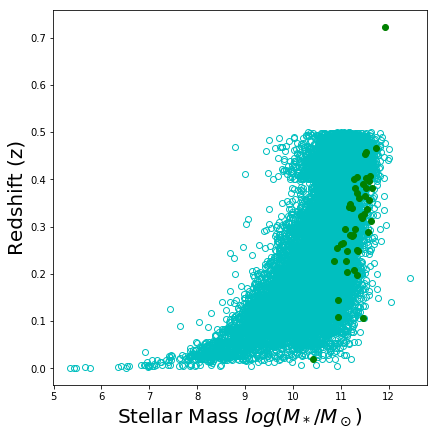

In [86]:
# Three-panel plot
from matplotlib.ticker import NullFormatter
nullfmt   = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.1, 0.65
lower, height = 0.1, 0.65
lower_h = left_h = left+width+0.02
    
rect_scatter = [left, lower, width, height]
#rect_histx = [left, lower_h, width, 0.2]
#rect_histy = [left_h, lower, 0.2, height]
    
    # start with a rectangular Figure
plt.figure(1, figsize=(8,8))
    
axScatter = plt.axes(rect_scatter)
#axHistx = plt.axes(rect_histx)
#axHisty = plt.axes(rect_histy)

binwidth = 0.5
bins=20

    # no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.plot(np.log10(gama_LRG.STELLAR_MASS), gama_LRG.Z, 'co', fillstyle = 'none')
axScatter.plot(np.log10(mac.STELLAR_MASS), mac.Z, 'go')

axScatter.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=20)
axScatter.set_ylabel(r'Redshift (z)', fontsize=20)

#axHisty.hist(spec.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHisty.hist(pg_sample.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='c', histtype = 'step', linewidth=3)

#axHistx.hist(np.log10(spec.STELLAR_MASS), range=[7,12], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHistx.hist(np.log10(pg_sample.STELLAR_MASS), range=[7,12], bins=bins,color='c', histtype = 'step', linewidth=3)
plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/mac_gama_lrg_zmass.png')

# K-S Tests of z and M*

In [87]:
sci.ks_2samp(mac.Z, gama_LRG.Z)

Ks_2sampResult(statistic=0.3289099836333879, pvalue=5.229230035792494e-05)

In [88]:
sci.ks_2samp(mac.STELLAR_MASS, gama_LRG.STELLAR_MASS)

Ks_2sampResult(statistic=0.6633660665575559, pvalue=4.57372752247549e-19)

# A-D tests of z and M*

In [ ]:
sci.anderson_ksamp([mac.Z,gama_LRG.Z])

In [ ]:
sci.anderson_ksamp([mac.STELLAR_MASS,gama_LRG.STELLAR_MASS])

## Now to see if Zoo passes the LRG cuts.

In [80]:
zoo = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_032020.csv')

In [89]:
# create variables for the criteria
# convert to Johnson magnitude system (or # out addition for AB)
g = photo_g.g# + 0.013
r = photo_r.r# + 0.226
i = photo_i.i# + 0.296

c_par = 0.7*(g - r) + 1.2*((r - i) - 0.18)
c_perp = (r - i) - (g - r)/4.0 - 0.18

# add columns c_par and c_perp to zoo
zoo['r'] = r
zoo['c_par'] = c_par
zoo['c_perp'] = c_perp

zoo

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,r,c_par,c_perp
0,0,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680,19.811590,0.742609,-0.033850
1,2,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370,19.662579,1.063929,-0.014327
2,4,1264,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11,1.856296,17.846043,1.084641,0.052289
3,5,2065,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11,2.212752,19.200987,0.946012,0.111426
4,6,2401,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237,1.131026e+11,0.956432,19.207859,0.392410,0.077943
5,7,2485,84050,175.79849,0.47814,0.365758,5.471000e+10,0.1190,1.402821e+11,1.086001,17.286449,0.567910,-0.025030
6,8,2524,7104,175.71213,0.83228,0.333333,1.768000e+10,0.0751,4.533333e+10,0.777126,17.592030,0.579694,0.059571
7,10,4670,55245,181.07958,-0.31553,0.314054,1.274000e+11,0.0936,3.266667e+11,1.868604,19.783960,0.555440,-0.003715
8,11,5098,70282,179.40308,0.12562,0.655352,4.256000e+10,0.1074,1.091282e+11,1.008252,17.508411,1.120424,0.049256
9,12,5698,185451,180.28326,-1.61006,0.302985,8.222000e+10,0.1079,2.108205e+11,1.398133,19.131847,0.567161,-0.002700


In [91]:
# Take Petrillo's 1st set of criteria for LRG (z < 0.4)
zoo_LRG_1 = zoo[(zoo.Z < 0.4) & (zoo.r < 20) & (abs(zoo.c_perp)) & (zoo.r < 14 + zoo.c_par/0.3)]
zoo_LRG_1 = zoo_LRG_1[abs(zoo_LRG_1.r) < 100]
zoo_LRG_1

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,r,c_par,c_perp
8,11,5098,70282,179.40308,0.12562,0.655352,4.256000e+10,0.1074,1.091282e+11,1.008252,17.508411,1.120424,0.049256
18,22,11076,136604,175.87349,-1.74167,0.316451,2.866000e+11,0.1060,7.348718e+11,2.633636,17.927132,1.226641,-0.015483
21,25,12397,324764,137.20387,1.72633,0.422757,4.647000e+10,0.1044,1.191538e+11,1.068579,17.401047,1.293173,-0.004201
24,28,13836,342699,216.90174,2.13250,0.457088,2.845000e+10,0.0876,7.294872e+10,0.912766,19.387873,1.940855,0.083289
27,32,15421,422113,129.41517,2.59516,0.499580,2.020000e+10,0.1202,5.179487e+10,0.656590,17.451962,1.418676,-0.045077
35,40,26107,238271,213.72842,1.57878,0.331694,7.078000e+10,0.1287,1.814872e+11,1.187781,18.607557,1.638089,-0.004892
